# Ответы на вопросы с помощью HuggingFace transformers

Данная лабораторная работа покрывает решение задачи ответа на вопросы с помощью языковых моделей, доступ к которым предоставляется через библиотеку `transformers`

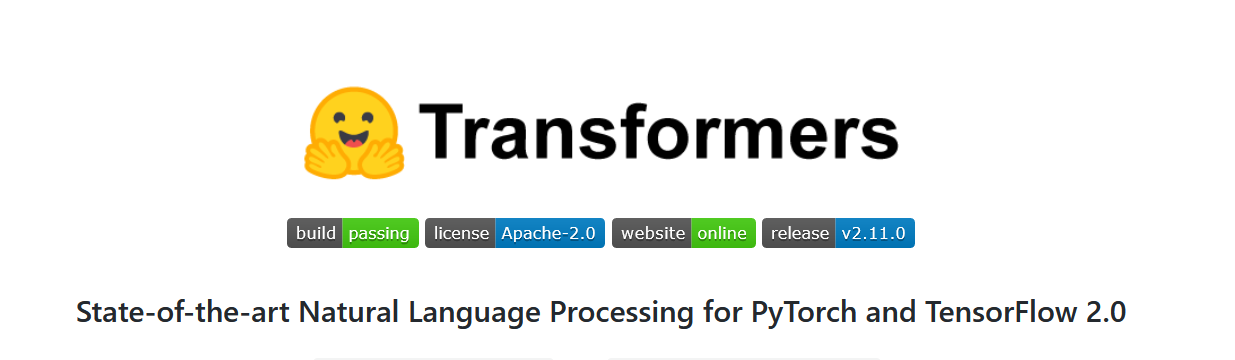

`transformers` -- это Python-библиотека, разрабатываемая компанией HuggingFace, специализирующейся на разработке инструментов для создания приложений машинног обучения

Данная библиотека предоставляет API для легкой загрузки и тренировки современных предварительно обученных нейросетевых моделей для следующих категорий задач:
* **Обработка естественных языков** -- перевод текстов с одного языка на другой, языковое моделирование, суммаризация, классификация текста, генерация текста
* **Компьютерное зрение** -- классификация изображений, обнаружение объектов, сегментация
* **Обработка звука** -- распознавания речи, классификация аудио
* **Мультимодальные задачи** -- ответы на вопросы по изображениям, классификация видео

`transformers` поддерживают взаимодействие между основными фреймворками для машинного обучения: PyTorch, Tensorflow и JAX. Представленные в `transformers` модели можно экспортировать в ONNX и TorchScript для развертывания в продакшне



Данная лабораторная работа покрывает следующие аспекты:
* Дообучение DistillBERT на наборе данных SQuAD для поика ответов на вопросы
* Использование готовой модели на основе трансформера T5 для поиска ответов на вопросы  

## Дообучение DistillBERT на наборе данных SQuAD

### Установка зависимостей

Для начала установим все необходимые зависимости

In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which i

### Загрузка набора данных SQuAD

In [ ]:
from datasets import load_dataset

squad = load_dataset("squad", split="train[:5000]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Разделим датасет на тренировочную и тестовую выборки  

In [ ]:
squad = squad.train_test_split(test_size=0.2)

И взглянем на один из примеров

In [ ]:
print(squad["train"][0])

{'id': '56cca3676d243a140015f052', 'title': 'IPod', 'context': 'The games are in the form of .ipg files, which are actually .zip archives in disguise[citation needed]. When unzipped, they reveal executable files along with common audio and image files, leading to the possibility of third party games. Apple has not publicly released a software development kit (SDK) for iPod-specific development. Apps produced with the iPhone SDK are compatible only with the iOS on the iPod Touch and iPhone, which cannot run clickwheel-based games.', 'question': 'What format is used for iPod game files?', 'answers': {'text': ['.ipg'], 'answer_start': [29]}}


Можно заметить, что примеры состоят из следующих полей:
* Идентификатор
* Название
* Контекст
* Вопрос
* Корректный ответ
* Указатель на начало ответа

### Инициализация токенизатора DistillBERT

Инициализируем токенизатор DistillBERT для обработки полей с вопросом и ответом  

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Создание функции препроцессинга  

Для задачи ответов на вопросы сущестуют типовые процедуры препроцессинга, которые включают:
* Усечение длинных контекстов, которые превышают максимальную входную длину последовательности для модели.
* Сопоставление начальной и конечной позиции ответа с оригиналом
* Нахождение начального и конечного токенов ответа

Данные процедуры реализованы в представленной ниже функции препроцессинга

In [ ]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Нахождение начала и конца контекста
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # Если ответ находится целиком внутри контекста, помечаем его как (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Иначе помечаем индексами начала и конца ответа
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Применим данную функцию ко всей тренировочной выборке

In [ ]:
tokenized_squad = squad.map(preprocess_function, batched=True, remove_columns=squad["train"].column_names)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Далее создадим объект `DefaultDataCollactor`

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

### Тренировка модели

Загрузим претрейненный DistillBERT с `AutoModelForQuestionAnswering`

In [ ]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("distilbert/distilbert-base-uncased")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Затем сделаем последние шаги перед запуском тренировки:
* Определим гиперпараметры с помощью `TrainingParameters`
* Инициализируем объект `Trainer` и передадим в него объект с параметрами, модель, набор данных и токенизатор и объект `DefaultDataCollector`

И запускаем собственно тренировку

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_qa_model",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## Использование готовой модели на основе трансформера T5 для поиска ответов на вопросы

На платформе HuggingFace уже существует множество моделей для решения задачи поиска ответов на вопросы  

Ниже представлен пример использования модели на основе T5

In [ ]:
from  transformers  import  AutoTokenizer, AutoModelWithLMHead, pipeline

# загружаем модель и токенизатор
model_name = "MaRiOrOsSi/t5-base-finetuned-question-answering"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)

# формируем вопрос и контекст
question = "What is 42?"
context = "42 is the answer to life, the universe and everything"

# формируем вход для модели
input = f"question: {question} context: {context}"
encoded_input = tokenizer([input],
                             return_tensors='pt',
                             max_length=512,
                             truncation=True)

# получаем выход модели
output = model.generate(input_ids = encoded_input.input_ids,
                            attention_mask = encoded_input.attention_mask)
output = tokenizer.decode(output[0], skip_special_tokens=True)
print(output)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1731: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the gene

The answer to life, the universe, and everything in it's entirety.


# Задания  

1. Запустите тренировку DistillBERT на датасете SQuAD, поменяв один или несколько из представленных гиперпараметров: коэффициент обучения, число эпох
2. Запустите модель T5 на любых трех англоязычных вопросах. Не забывайте про то, что помимо собственно вопроса нужно модели предоставить контекст для поиска ответа
3. Дополнительное. Представленная модель T5 может работать только с английцским языком. Попробуйте дополнить пайплайн поиска ответа на вопросы таким образом, чтобы появилась возможность работы с русским языком, т. е. вопрос, контекст и ответы должны формироваться на русском языке.

Подсказка: для третьего задания могут пригодиться открытые модели для задачи машинного перевода, которые также есть на HuggingFace:
* Для перевода с en на ru: https://huggingface.co/glazzova/translation_en_ru
* Для перевода с ru на en: https://huggingface.co/facebook/wmt19-ru-en